In [3]:
URL_BASE="https://raw.githubusercontent.com/ggonzalesd/Deep-Learning-Project/dev"
!curl $URL_BASE/callback.py --output callback.py
!curl $URL_BASE/brain_tumor_dataset.py --output brain_tumor_dataset.py
!curl $URL_BASE/models_01.py --output models_01.py
!curl $URL_BASE/plots.py --output plots.py
!curl $URL_BASE/trainer.py --output trainer.py

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2515  100  2515    0     0  13594      0 --:--:-- --:--:-- --:--:-- 13594
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   640  100   640    0     0   3076      0 --:--:-- --:--:-- --:--:--  3076
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2035  100  2035    0     0  10544      0 --:--:-- --:--:-- --:--:-- 10489
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2660  100  2660    0     0  13502      0 --:--:-- --:--:-- --:--:-- 13502
  % Total    % Received % Xferd  Average Speed   Tim

In [4]:
import h5py                                           # Read .Mat Files
import random                                         # Get random integers
import pandas as pd                                   # Read CSV
import numpy as np                                    # Transform and save arrays
from skimage.draw import polygon                      # Create images from points
from prettytable import PrettyTable # Table of results

import torch                                          # Framework
from torch import optim                               # optim: Adam, SDG
from torch import nn

from torch.utils import data                          # Data
from torchvision import transforms                    # Transform dataset images

import matplotlib.pyplot as plt                       # Visualize images and more

import plots
from brain_tumor_dataset import BrainTumorDataset     # Dataset
from callback import EarlyStopping, ModelCheckpoint
from trainer import Trainer          # Trainer Class
from models_01 import InceptionModel

# Preprocessing Dataset | (from .mat to .npy)
Download and unzip dataset

In [ ]:
!curl https://figshare.com/ndownloader/articles/1512427/versions/5 --output data.zip
!mkdir tmp_dataset
!mkdir dataset
!unzip data.zip -d ./tmp_dataset
!for file in ./tmp_dataset/*.zip; do unzip $file -d ./tmp_dataset/; done
!rm ./tmp_dataset/*.zip

Convert .mat to .npy

In [6]:
data_tmp = {'image':[], 'label':[]}
index = 0
for i in range(3064):
  with h5py.File(f"tmp_dataset/{i+1}.mat", 'r') as f:
    image = f.get('cjdata/image')
    img = np.array(image, dtype=np.float32)
    if img.shape == (512, 512):
      border = np.array(f.get('cjdata/tumorBorder')).reshape((-1, 2))
      name = f"{index+1}.npy"
      img = img / img.max()

      mask = np.zeros_like(img, dtype=np.float32)
      rr, cc = polygon(border[:,0], border[:,1], img.shape)
      mask[rr,cc] = 1.0

      result = np.stack([img, mask], axis=2)

      np.save("./dataset/"+name, result)
      data_tmp['image'].append(name)
      data_tmp['label'].append(np.array(f.get('cjdata/label'), dtype=np.int64).item()-1)
      index += 1
!rm -rf tmp_dataset

In [11]:
df = pd.DataFrame(data_tmp)
df.to_csv('./dataset/data.csv', index=False)
df.head()
del df, data_tmp

In [7]:
def split_dataset(dataset, train_size=0.8):
  n = len(dataset)
  n_train = int(n*train_size)
  n_val = n - n_train
  train_dataset, val_dataset = data.random_split(dataset, [n_train, n_val])
  return train_dataset, val_dataset

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using {}'.format(device))

Using cuda


In [9]:
seed = 42
random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
#torch.backends.cudnn.deterministic = True
#torch.backends.cudnn.benchmark = False

In [12]:
# Load Dataset
dataset = BrainTumorDataset(
  csv_file='dataset/data.csv',
  root_dir='dataset',
  transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
  ])
)

train_data, test_data = split_dataset(dataset)
len(train_data), len(test_data)

(2439, 610)

In [13]:
# Split train_data for training and validation
train_set, val_set = split_dataset(train_data, train_size=0.75)

print('Original dataset size: ', len(dataset))
print('---------------------------')
print('Training data size: ', len(train_set))
print('Validation data size: ', len(val_set))
print('Test data size: ', len(test_data))

Original dataset size:  3049
---------------------------
Training data size:  1829
Validation data size:  610
Test data size:  610


In [14]:
# Create Loaders
train_dl = data.DataLoader(train_set, batch_size=32, shuffle=True)
val_dl = data.DataLoader(val_set, batch_size=32, shuffle=False)
test_dl = data.DataLoader(test_data, batch_size=32, shuffle=False)

print('Number of batches')
print('---------------------')
print('Training data: ', len(train_dl))
print('Validation data: ', len(val_dl))
print('Test data: ', len(test_dl))

Number of batches
---------------------
Training data:  58
Validation data:  20
Test data:  20


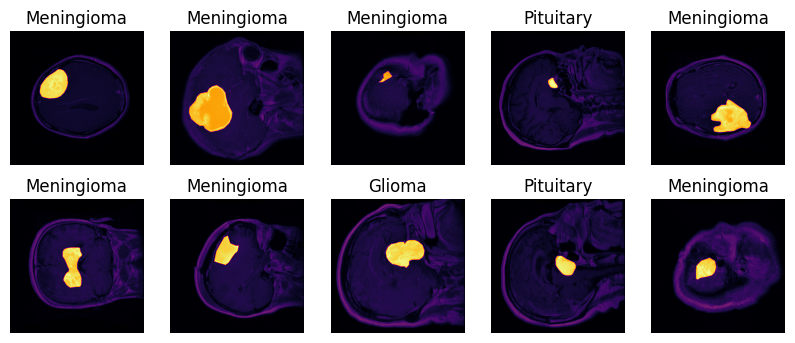

In [15]:
labels = ['Meningioma', 'Glioma', 'Pituitary']
X_batch, y_batch = next(iter(val_dl))
plt.figure(figsize=(10, 4))
for i in range(10):
  image = (X_batch[i]*0.5 + 0.5).numpy()
  
  mask = 0.5*image[0,:,:] + image[1,:,:]

  plt.subplot(2, 5, i+1)
  plt.axis('off')
  plt.title(str(labels[y_batch[i].item()-1]))
  plt.imshow(mask, cmap='inferno')

In [16]:
model = InceptionModel()

num_epochs = 5

optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-7)

inception_model_ckp = ModelCheckpoint('inception_model.pt', mode='min', monitor='val_loss', verbose=False)

trainer = Trainer(inception_model_ckp)

finetuning_densenet_results = trainer.train(train_dl, val_dl, model, num_epochs, optimizer, device)

Epoch 1/5:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (1/5): time=00:53, train_loss=0.417, val_loss=1.832, train_acc=0.839, val_acc=0.389


Epoch 2/5:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (2/5): time=00:43, train_loss=0.204, val_loss=0.314, train_acc=0.931, val_acc=0.890


Epoch 3/5:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (3/5): time=00:46, train_loss=0.165, val_loss=0.254, train_acc=0.943, val_acc=0.895


Epoch 4/5:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (4/5): time=00:36, train_loss=0.121, val_loss=2.356, train_acc=0.960, val_acc=0.413


Epoch 5/5:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (5/5): time=00:26, train_loss=0.096, val_loss=0.096, train_acc=0.969, val_acc=0.964


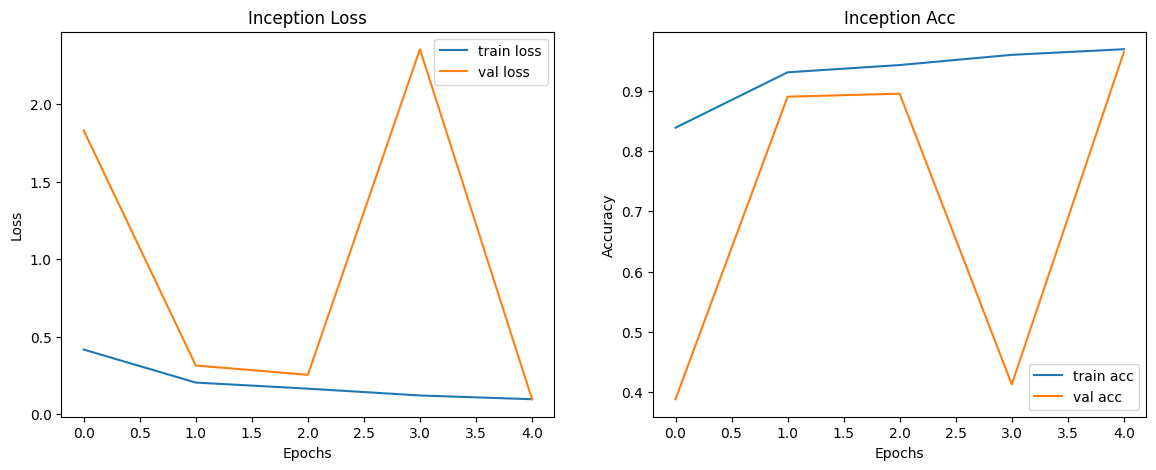

In [17]:
plots.plot_model_results("Inception", finetuning_densenet_results)

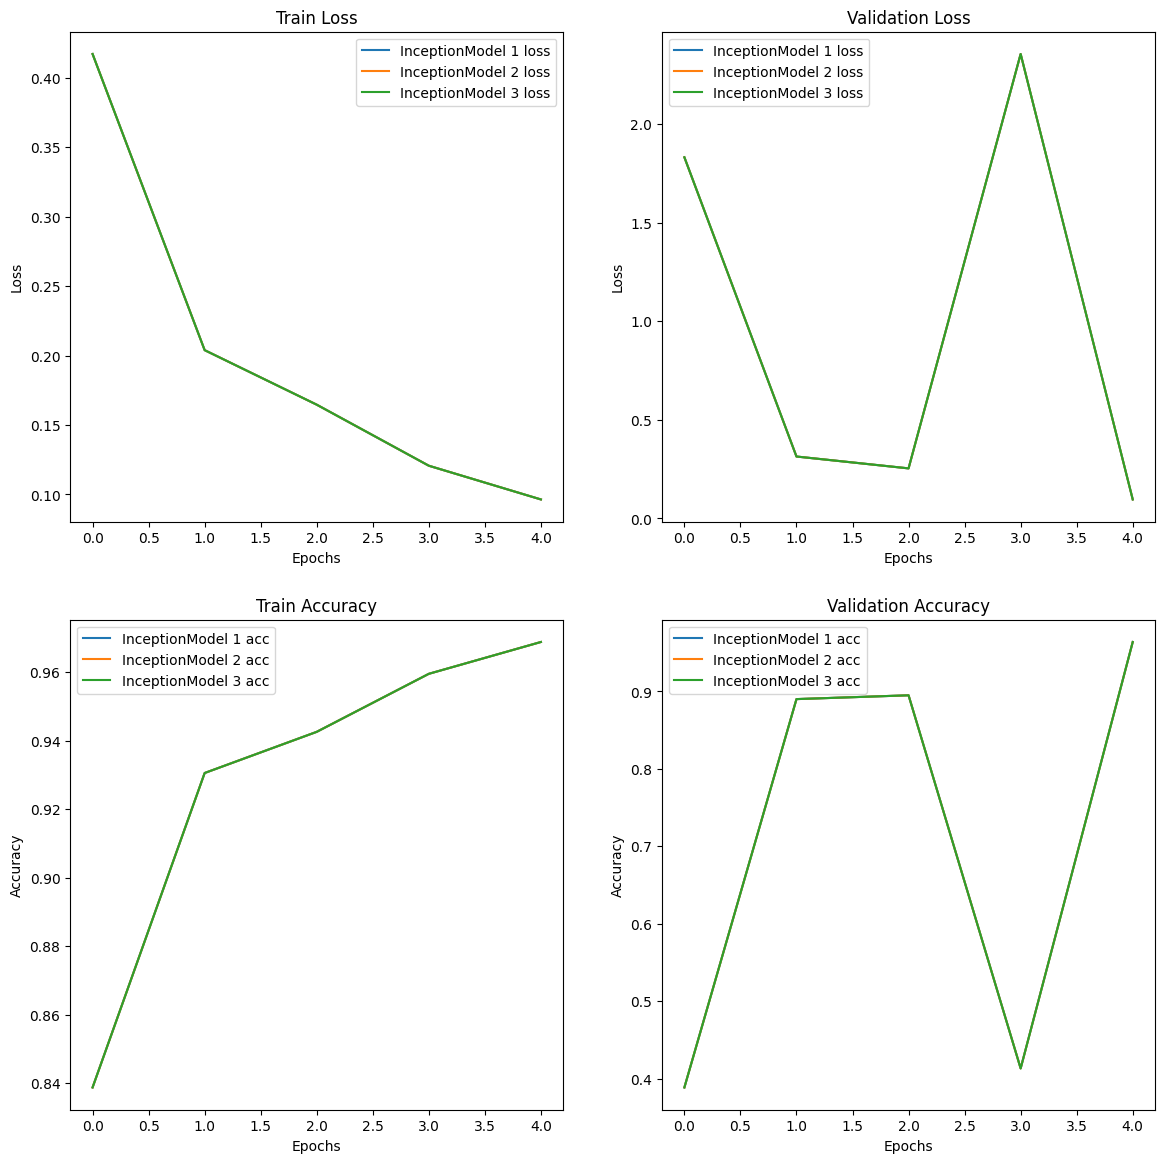

In [18]:
plots.plot_model_compare([
  ["InceptionModel 1", finetuning_densenet_results],
  ["InceptionModel 2", finetuning_densenet_results],
  ["InceptionModel 3", finetuning_densenet_results]
])

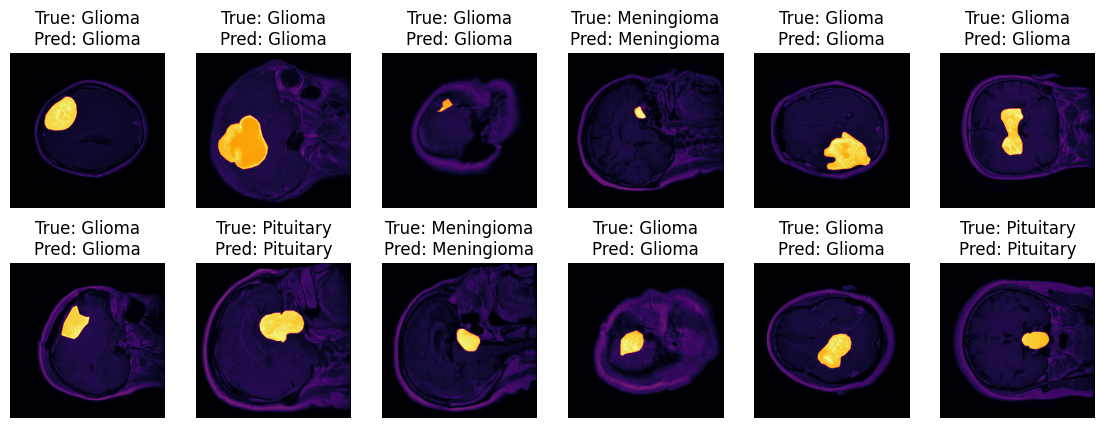

In [19]:
plots.display_random_batch_detector(model, val_dl)

In [21]:
results = [{'train_loss': random.random(), 'val_loss': random.random(), 'train_acc': random.random(), 'val_acc': random.random() } for _ in range(5)]
headers = ["Model", "Train loss", "Val Loss", "Train Acc", "Val Acc", "Paramers"]
plots.print_table(headers,
  [plots.results_to_row("model", inception_model_ckp.best_results) + [0]]
)

+-------+------------+----------+-----------+---------+----------+
| Model | Train loss | Val Loss | Train Acc | Val Acc | Paramers |
+-------+------------+----------+-----------+---------+----------+
| model |   0.096    |  0.096   |   0.969   |  0.964  |    0     |
+-------+------------+----------+-----------+---------+----------+
